We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
**768-dimensional feature vector of histograms of R, G, B channels
for each frame**. The difference between frames is determined by
calculating the **mean square error** of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is **greater than 200**, it
is considered to belong to different shots. In order to improve the
quality of the data, we **remove shots in which the mean square
errors between all pairs of frames are less than 10** (as they are
too uniform), and **the shot with a length less than 8 frames**.
Then we **filter out video frames that are too dark or too faded
in color**. Finally we get a total of 
1096 video sequences from 6 animations, with a total of 29,834 images. 
Each video sequence
has 27 frames on average. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os
import shutil
import pandas as pd
from skimage.metrics import structural_similarity


Let's create the frames.

In [14]:
def VidToFrames_2 (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        resized = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
        cv2.imwrite("{}/{}.png".format(folderName, str(count).zfill(5)), resized)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

def VidToFrames (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    print(success)
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        cv2.imwrite("{foldername}/{frameNum}.png".format(foldername= folderName, frameNum=str(count)), image)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

# for i in glob.glob("mp4/*.mp4")[1:]:
#     print(i)
#     destination = i.split('.mp4')[0].split('-',1)[-1]
#     os.mkdir(destination)
#     VidToFrames_2(i, destination)

mp4/berdnite-Hkz0NcKPzMs.mp4
30 640 360
2087 frames in file
mp4/Scale of Things in Minecraft (UPDATED VERSION in the description!)-iRBmUQQzpWQ.mp4
30 640 360
6052 frames in file
mp4/Private School-IwxWmKsVR5U.mp4
29 640 360
11453 frames in file
mp4/I have APHANTASIA (and you may too...without realising it!)-ewsGmhAjjjI.mp4
24 640 360
18566 frames in file
mp4/Being a Boba Barista (Work Stories)-so1_5hYUEE8.mp4
29 640 360
9584 frames in file
mp4/20 ART STYLES CHALLENGE!!! _ Melanie Martinez-6wS_uON5s6Q.mp4
29 640 360
28670 frames in file
mp4/'just buy a new one'-hpQQohcHk9Q.mp4
24 640 360
312 frames in file
mp4/How KSI Saved Logan Paul's Career-gA0bi-bFEYs.mp4
23 640 360
9779 frames in file
mp4/Arizona Adventure! (ft. TheOdd1sOut)-uDvPIKM-L1o.mp4
29 640 360
21516 frames in file
mp4/Actually, I Quit DanPlan-RlU32AfEVeU.mp4
29 640 360
12786 frames in file
mp4/Being Mute for 3 Years-F8A-tXp09fs.mp4
29 640 360
20136 frames in file
mp4/The Kindergarten Disstrack-18msRdBF11A.mp4
29 640 360
104

Now that we have folders with frames from each video for each channelId, we can start the analysis. There is two parts to this: 
1. Color analysis
2. Motion analysis

### Part I  <br/>
***Color Analysis*** <br/>
Is there a correlation between color and subcount?

In [41]:
def binAndPlot(some_list):
    sorted_list = sorted(some_list)
    sorted_counted = Counter(sorted_list)
    range_length = list(range(int(max(some_list)+1))) # Get the largest value to get the range.
    data_series = {}

    for i in range_length:
        data_series[i] = 0 # Initialize series so that we have a template and we just have to fill in the values.
    for key, value in sorted_counted.items():
        data_series[key] = value
    data_series = pd.Series(data_series)
    x_values = data_series.index
    plt.hist(some_list, edgecolor="yellow", color="green")
    plt.show()

### Part 2:
*** Motion Analysis ***

Is there a correlation between the amount of animation and subcount?

In my head, I should technically analyze how much each frame differs from each other. 
However, color is a value that is assigned to each pixel in a frame.

So we are going to get rid of color. We're not completely getting rid of it tho- any changes due to color will be detected (example)- because we are using
ahem ahem an eXtended difference-of-Gaussians to extract the lines. So we're basically changing the data to put less weight on color because it's already been accounted for in Part I.

 There was a time when I was interested in colorization machine learning techniques. Honestly, I still am, just less than this project. 

 There was a paper called [Deep Line Art Video Colorization with a Few References](https://arxiv.org/abs/2003.10685) that I spent some time generating data for. It was only after I generated all the data that I realized I don't have the resources (GPU, money, honestly, motivation was the biggest factor)

> We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
768-dimensional feature vector of histograms of R, G, B channels
for each frame. The difference between frames is determined by
calculating the mean square error of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is greater than 200, it
is considered to belong to different shots. In order to improve the
quality of the data, we remove shots in which the mean square
errors between all pairs of frames are less than 10 (as they are
too uniform), and the shot with a length less than 8 frames.
Then we filter out video frames that are too dark or too faded
in color. Finally we get a total of 1096 video sequences from 6
animations, with a total of 29,834 images. Each video sequence
has 27 frames on average. 

In my case, I got around 28k iumages with 32 frames per scene on average.

I'm going to use the data collection method stated above, with a slight variation


In [15]:
with open('../channelId_to_mostViewedVidId.json', 'r') as j:
    channelId_to_mostViewedVidId = json.loads(j.read())

LIST_OF_CHANNEL_IDS= channelId_to_mostViewedVidId.keys()
print(len(LIST_OF_CHANNEL_IDS))

62


In [ ]:
with open('../masterSheetOfChannelIdToListOfVidInfos.json', 'r') as j:
    masterSheet = json.loads(j.read())

channelId_to_mostViewedVidInfo = {}

for channelId in LIST_OF_CHANNEL_IDS:
    mostViewedVidId = channelId_to_mostViewedVidId[channelId]
    for vidInfo in masterSheet[channelId]:
        if vidInfo['vidId'] == mostViewedVidId:
            channelId_to_mostViewedVidInfo[channelId] = vidInfo
channelId_to_mostViewedVidInfo
# print(len(channelId_to_mostViewedVidId))

In [17]:
import regex as re
df = pandas.DataFrame.from_dict(channelId_to_mostViewedVidInfo).T
not_candidate_vidIds= ['kQEtRoyFfI8', 'hpQQohcHk9Q', '6wS_uON5s6Q', 'RlU32AfEVeU', 'iVqhzEaJhDw', 'Xnv7JGqjaAo', '18msRdBF11A', 'Ln4AnsWNUQI', 'Hkz0NcKPzMs']

#https://en.wikipedia.org/wiki/ISO_8601#Durations
for channelId, row in df.iterrows():
    x= row['duration']
    m=0
    s=0
    try:
        m, s = re.findall('PT(\d+)M(\d+)S',x)[0]
    except:
        s = re.findall('PT(\d+)S',x)[0]
    if int(m)*60+int(s) < 210:
        not_candidate_vidIds.append(row['vidId'])
not_candidate_vidIds = set(not_candidate_vidIds)
candidateVideos = list(set(df.vidId)- not_candidate_vidIds)
df = df[df.vidId.isin(candidateVideos)]
print(len(df))
df

43


,vidId,publishTime,vidTitle,duration,viewCount,likeCount,commentCount,topicCategories,description
UCsDmESjqNPukDmVnuneLrqw,EcgkRp2IUsc,2017-10-26T01:05:22Z,My Hot Babysitter Got Me In Trouble,PT6M30S,35960829,840561,75550,"[https://en.wikipedia.org/wiki/Entertainment, ...",First Name Babysitter. Last Name Trouble. \nGE...
UCY6Ij8zOds0WJEeqCLOnqOQ,kbCah6yhYRs,2019-06-11T11:00:07Z,Descendants doesn&#39;t make any sense...,PT16M8S,9850298,263259,22459,"[https://en.wikipedia.org/wiki/Entertainment, ...",Descendants doesn't make any sense animation\n...
UClN24S5-fc7LD0JJW0FdGWw,ewsGmhAjjjI,2018-10-09T20:50:50Z,I have APHANTASIA (and you may too...without r...,PT12M54S,6041764,320113,72063,"[https://en.wikipedia.org/wiki/Hobby, https://...",So...yeah. I'm an artist that can't see pictur...
UC3iNdSV_RQU7DHTGpqEW96w,gA0bi-bFEYs,2018-06-22T19:20:36Z,How KSI Saved Logan Paul&#39;s Career,PT6M48S,20326487,514050,95645,"[https://en.wikipedia.org/wiki/Entertainment, ...",This KSI vs Logan Paul fight is interesting to...
UC_52i6mlrzOZs_NEuSepzAg,so1_5hYUEE8,2017-09-20T22:12:54Z,Being a Boba Barista (Work Stories),PT5M20S,2196765,58187,3756,[https://en.wikipedia.org/wiki/Lifestyle_(soci...,Get it? “B”eing a “B”oba “B”arista “b”y “B”ill...
UCgCKYs56-LKEPGQ99DzqQOg,W8P5ewPk9fM,2019-01-18T20:00:06Z,Why I Dont Want a Hot Wife (Ft. Emirichu),PT8M7S,2319758,115467,5838,[https://en.wikipedia.org/wiki/Entertainment],"This week, we talk about one of the things I g..."
UC2Ds30pkifFVD0CE08wF50g,Mv8OkBjySGQ,2017-09-15T00:08:53Z,My Super HOT English Teacher (Animation),PT8M5S,9256911,303955,26316,"[https://en.wikipedia.org/wiki/Entertainment, ...","I have so many more stories, so subscribe and ..."
UC7UGbBVrqLlq6CRxWWUmyKw,2juKkLxdQo0,2019-05-11T17:14:40Z,"By the way, Are You a Sociopath?",PT11M23S,15162571,587421,45079,"[https://en.wikipedia.org/wiki/Entertainment, ...",Dragon City Sponsor link here: https://spons....
UCn1XB-jvmd9fXMzhiA6IR0w,eNGgfPs0Xp8,2016-09-26T21:49:18Z,Crushes,PT7M27S,31840209,912487,86962,"[https://en.wikipedia.org/wiki/Entertainment, ...",Get Crunchyroll Premium Ad Free for 30 Days: h...
UCFeqAfEuKm7lIg2ddQzh61A,rlSXaDq3uOk,2019-06-29T18:02:32Z,Childhood Crushes 2,PT17M16S,23048562,757408,83021,"[https://en.wikipedia.org/wiki/Entertainment, ...",Get Honey for FREE and start saving money toda...


Get lineart for all frames

couple that do not fit the criteria:: vidIds [kQEtRoyFfI8- gameplay, hpQQohcHk9Q- too short. not commentary, 6wS_uON5s6Q- speeddrawing, RlU32AfEVeU- footage apparently from another youtuber, iVqhzEaJhDw- too short, Xnv7JGqjaAo- speeddraw, iRBmUQQzpWQ- simply not animation, 18msRdBF11A- not animation, Ln4AnsWNUQI- not animation, Hkz0NcKPzMs- too short]



The plan is to find the distribution of DIFF. It'll vary based on the artist.

> frames/Mv8OkBjySGQ


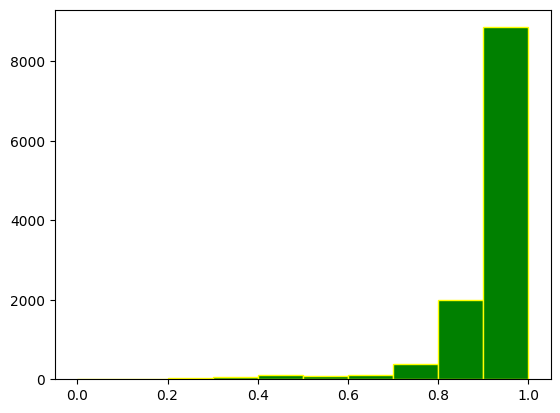

> frames/2yFCyPX3kT0


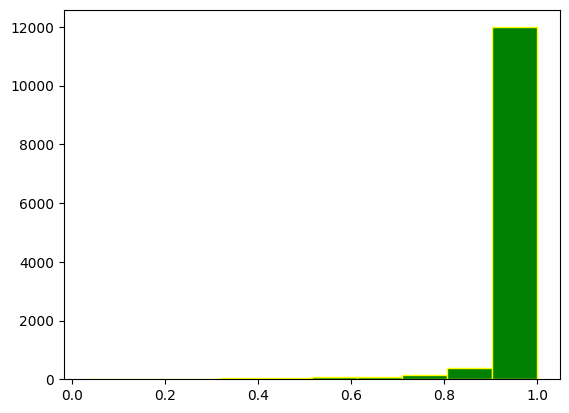

> frames/OyDLuom4KGs


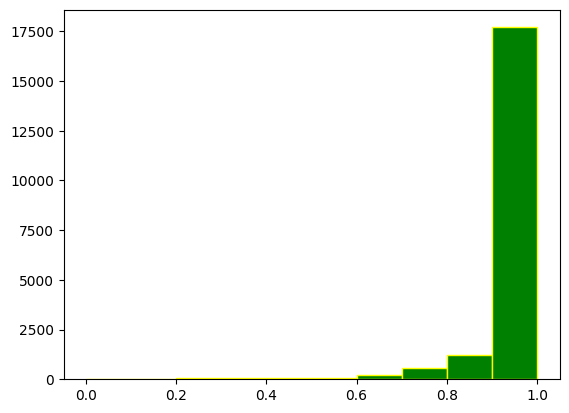

> frames/2juKkLxdQo0


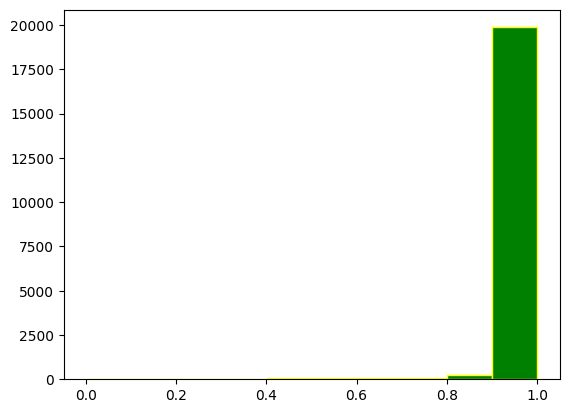

> frames/uDvPIKM-L1o


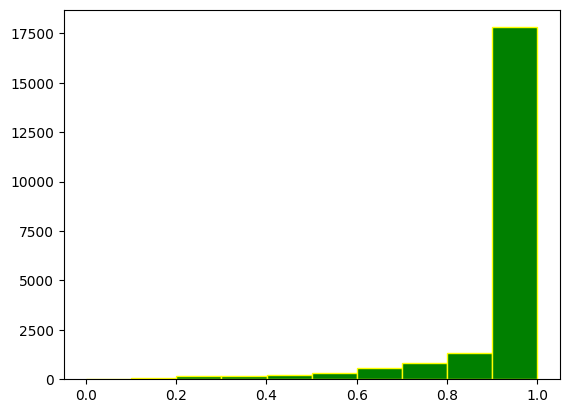

> frames/2bGkEK8I6zQ


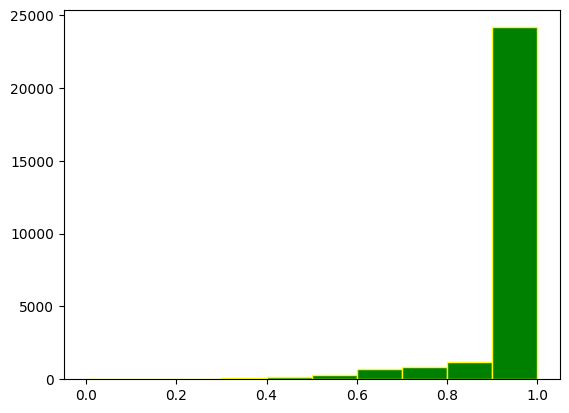

> frames/IwxWmKsVR5U


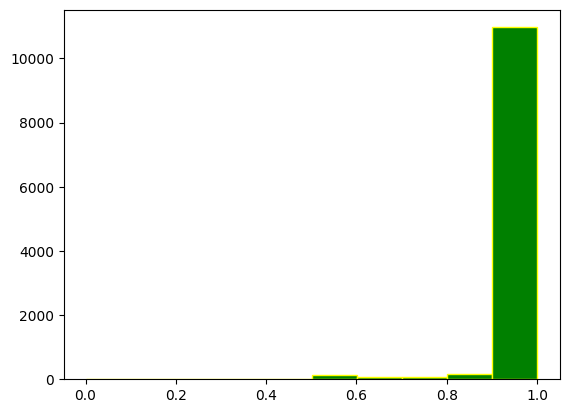

> frames/EcgkRp2IUsc


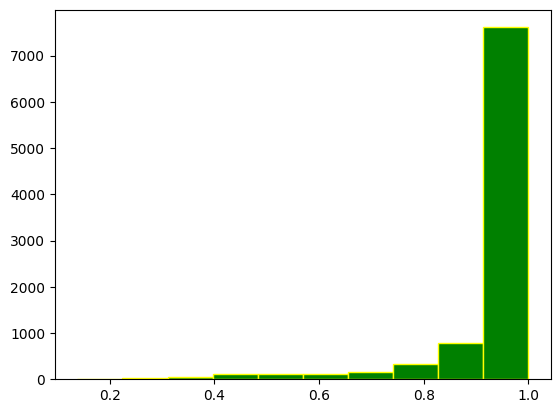

> frames/_uk_6vfqwTA


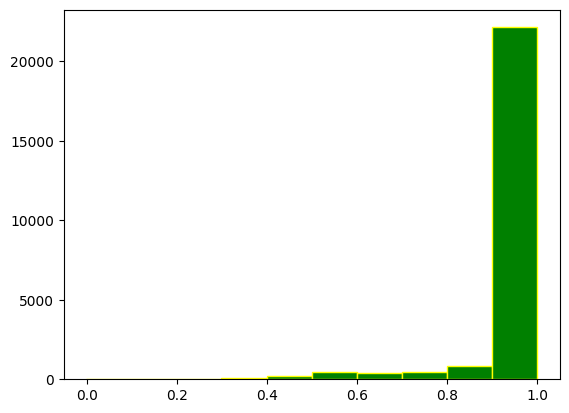

> frames/cZ_CnLE6SPo


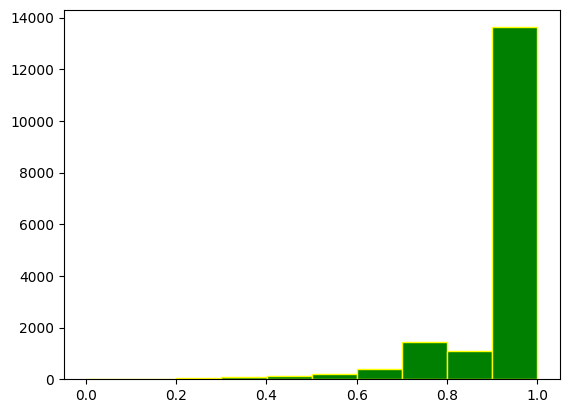

> frames/Vm6Yu2N-ePI


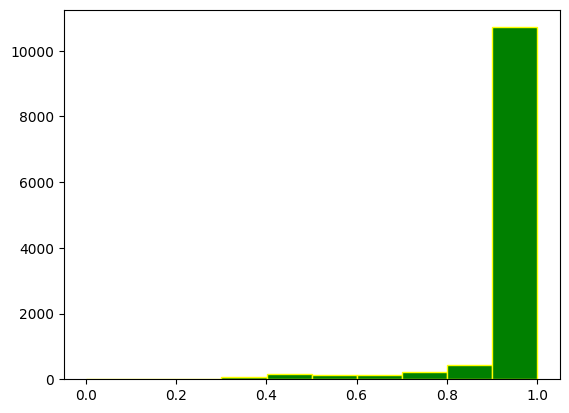

> frames/gA0bi-bFEYs


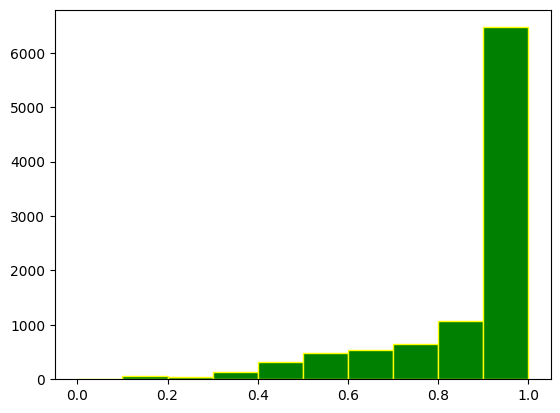

> frames/O0hyjRF6quc


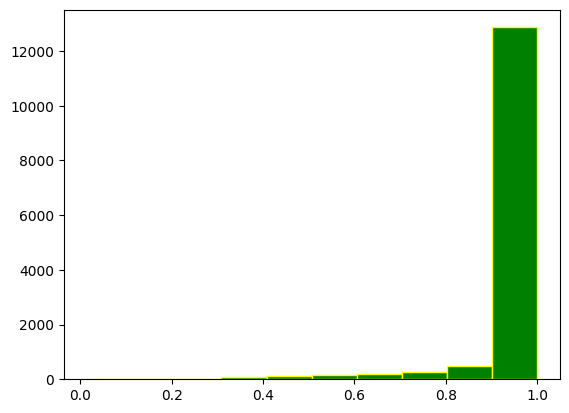

> frames/o0zjRGRYEhk


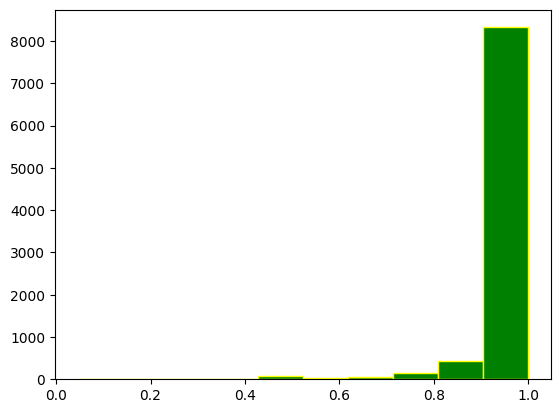

> frames/vv2vPAzj8S4


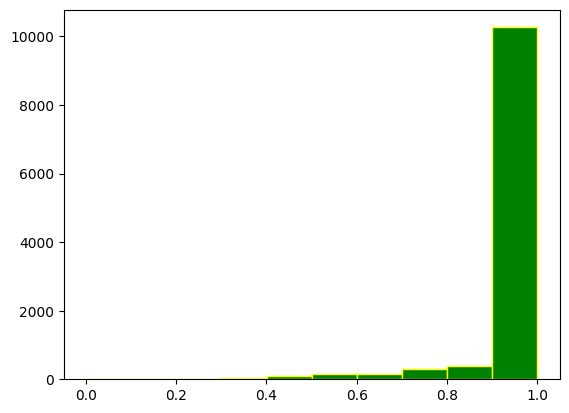

> frames/5pMckBGWzAY


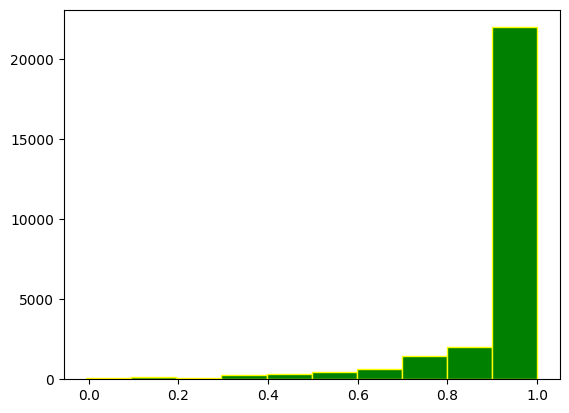

> frames/n4CAhXpyVCI


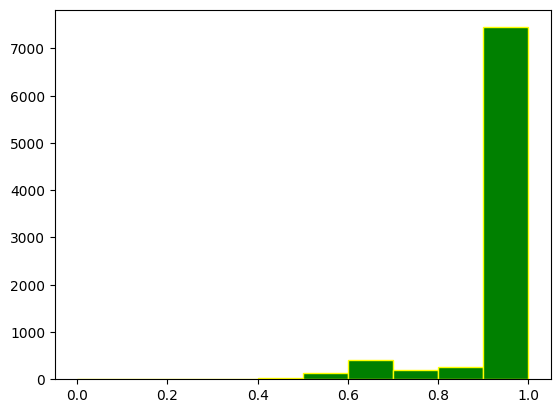

> frames/0Vxp_Lj2b-E


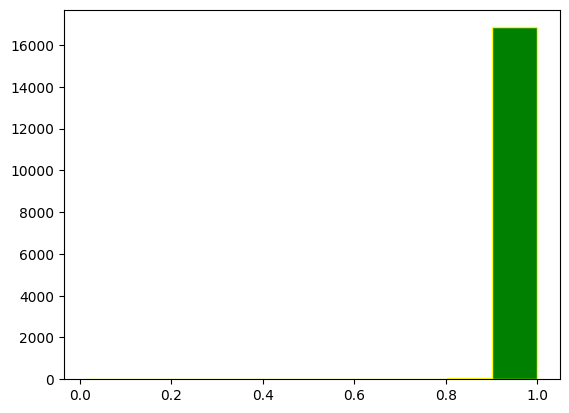

> frames/nHgRnjqLmtM


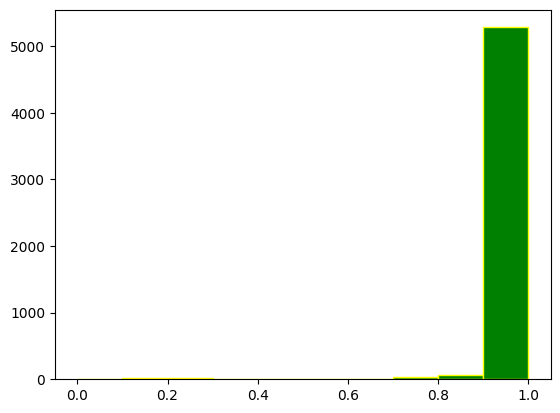

> frames/A6V1QujNz8s


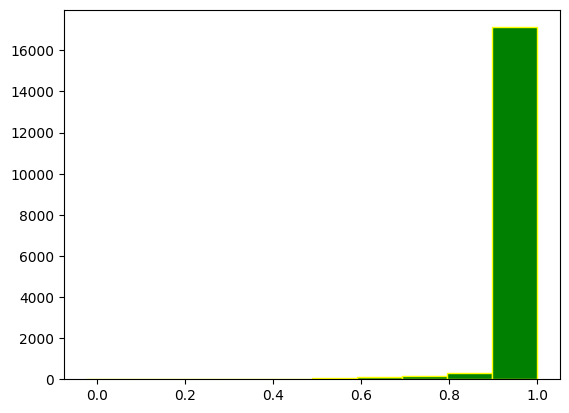

> frames/eNGgfPs0Xp8


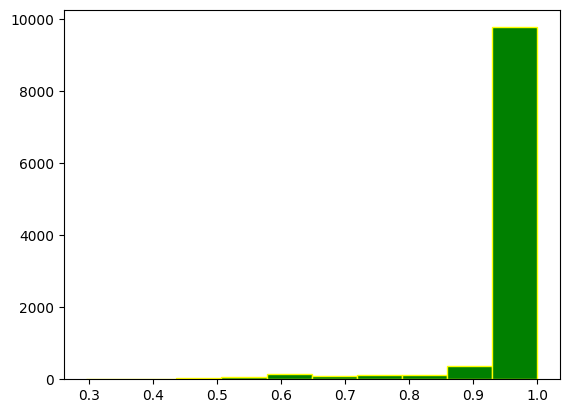

> frames/oKLbOxLJfRg


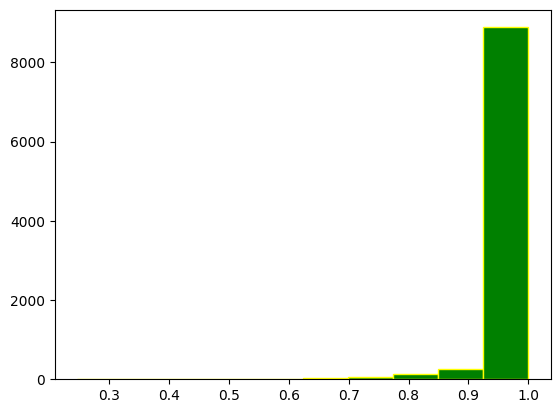

> frames/rlSXaDq3uOk


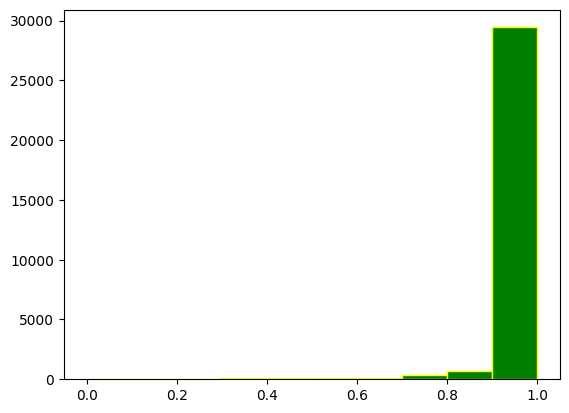

> frames/so1_5hYUEE8


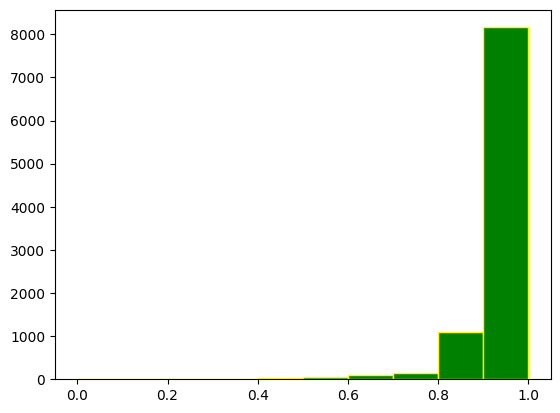

> frames/de8PRd_d7kg


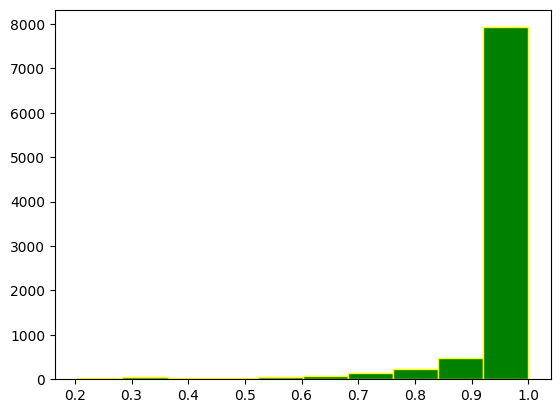

> frames/1lME1ARYMBI


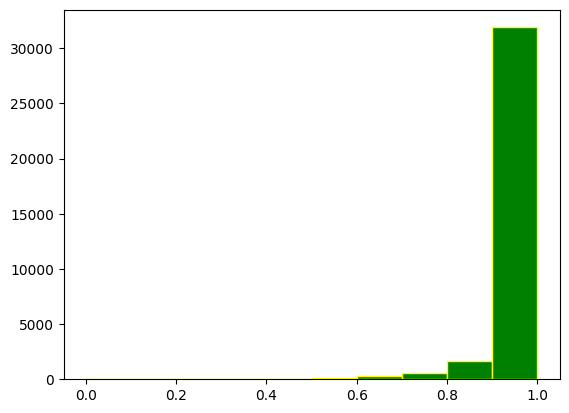

> frames/PgajWuZA408


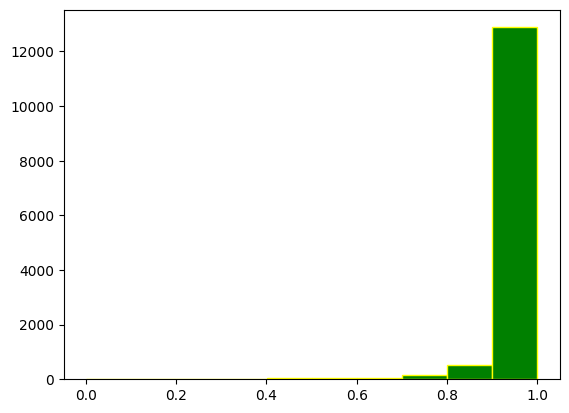

> frames/vuk2NZ0YKAE


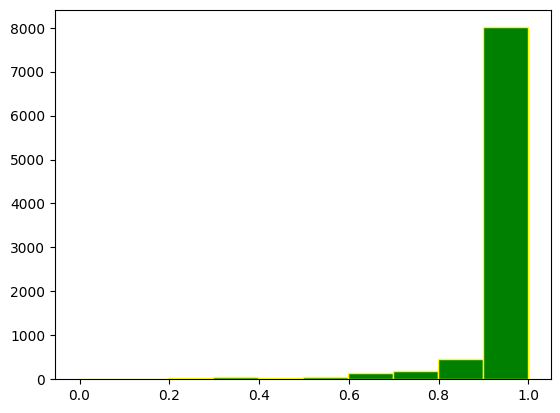

> frames/F8A-tXp09fs


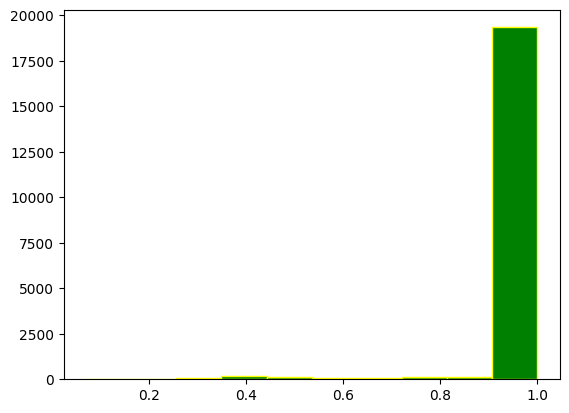

> frames/plSyrHqUh78


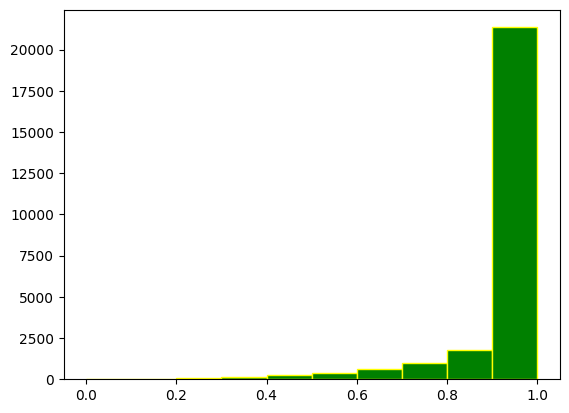

> frames/WXNmSruTWIA


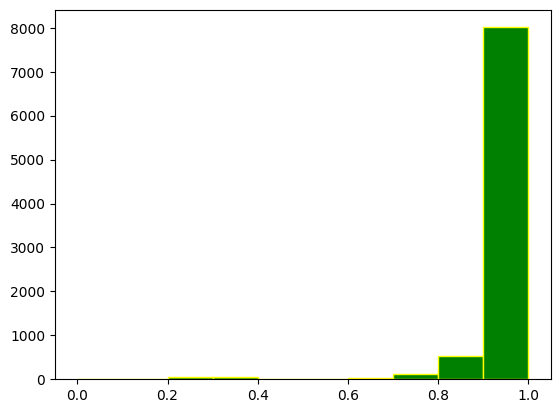

> frames/Y7lYeRqhQ9Q


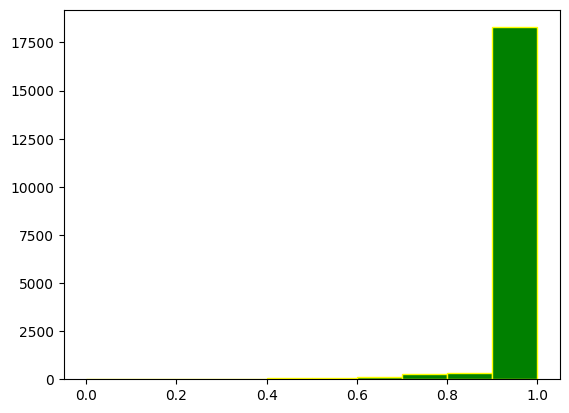

> frames/kbCah6yhYRs


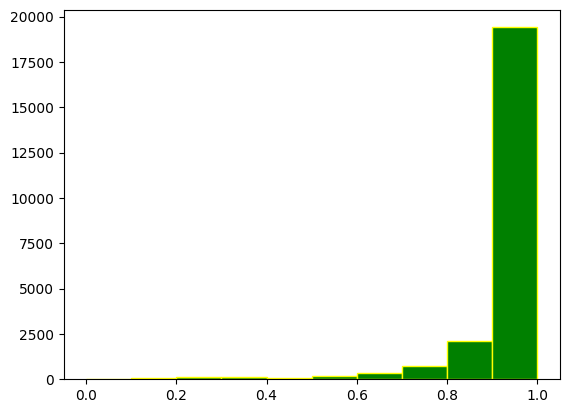

> frames/0TlV3w1YGqk


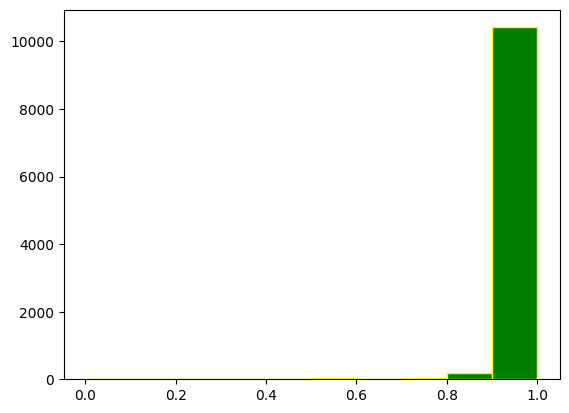

> frames/uqJKryP1-8M


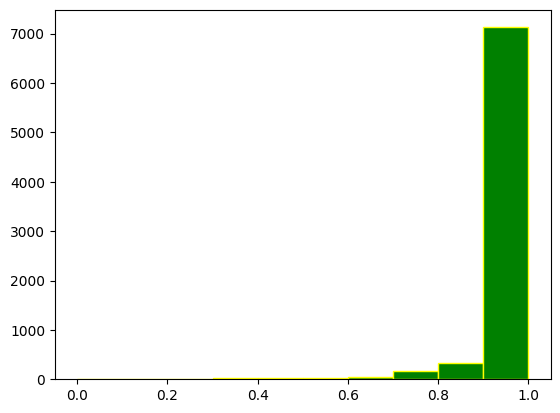

> frames/7WSo1Uw-p_g


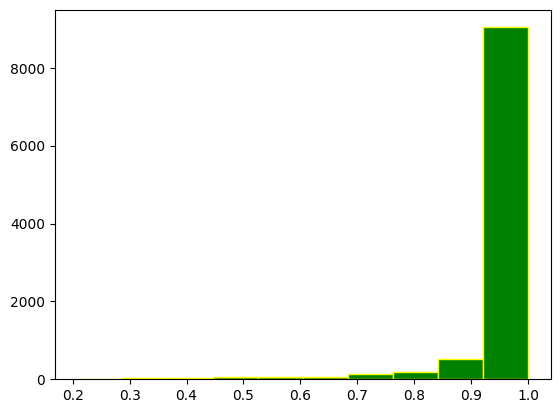

> frames/P2EjH7l_N70


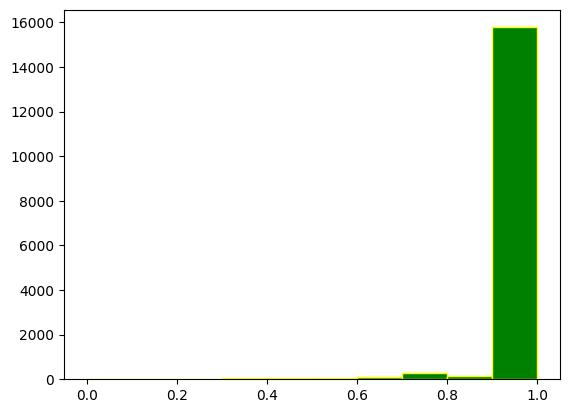

> frames/BErOLQBZ6c8


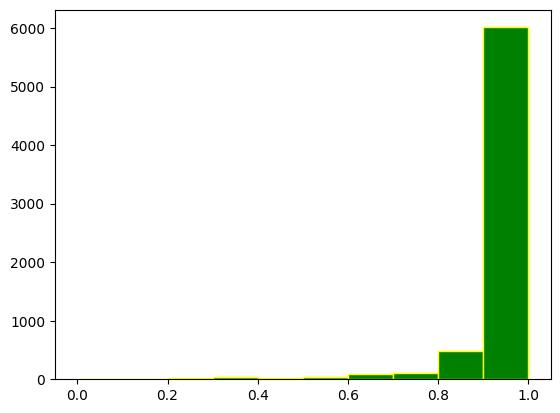

> frames/ewsGmhAjjjI


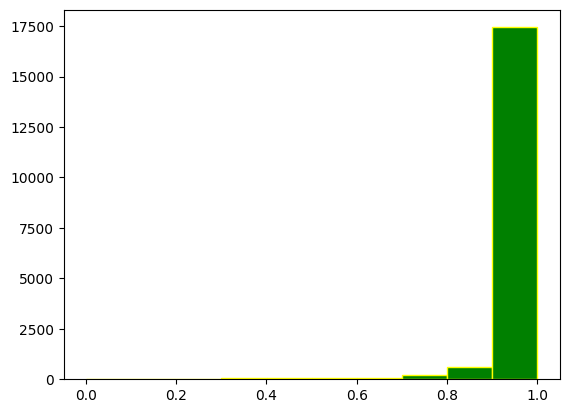

> frames/rnQlkpOFgm8


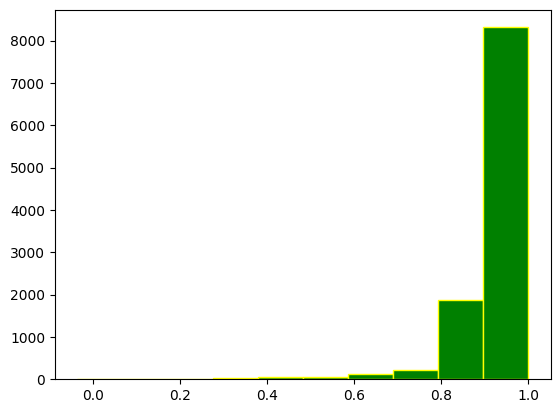

> frames/W8P5ewPk9fM


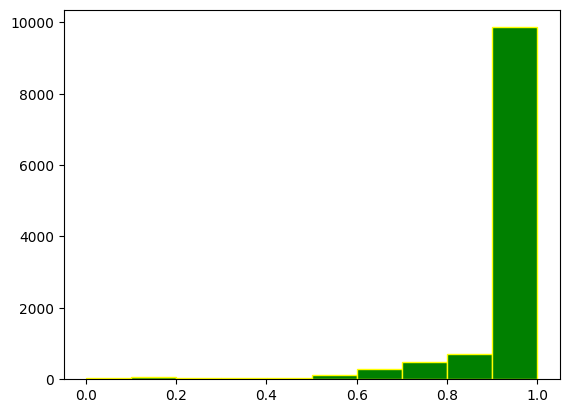

> frames/9oUpImsyf4Y


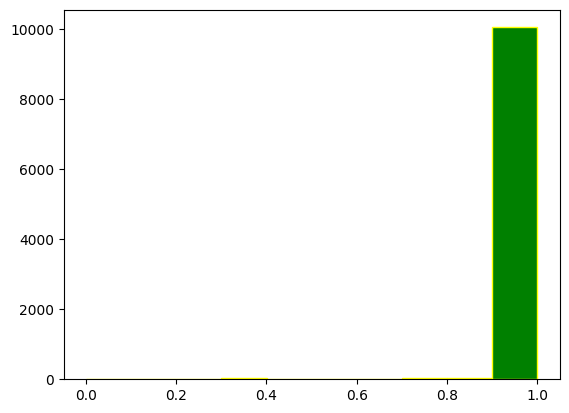

> frames/7FnQrNFyWy8


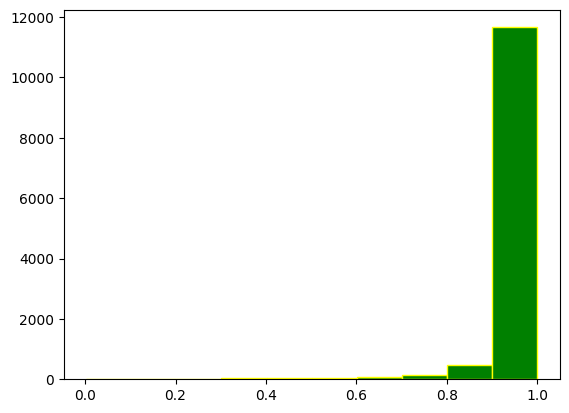

In [66]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from IPython.display import Image, display

dictOfVidIdToDiffMse = {}

def getFeatureVectorOfImage_color (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        vectors.append(hist)
        # plt.plot(hist, color = col)
        # plt.xlim([0, 256])
    # plt.show()
    vectors = np.vstack(vectors)
    return vectors

def getFeatureVectorOfImage (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    vectors = np.vstack(hist)
    return vectors

def MSE_images (vA, vB):
    return np.sum(np.square(np.subtract(vA, vB)))

def DIFF_images(vA, vB):
    return (np.abs(vA - vB)).mean()

#https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf
def removeLowDiff_andDemo(folderName):
    vidId = folderName.split('/')[-1]
    print(">", folderName)
    frameList = glob.glob(folderName+'/*.png') #unfortunately, doesn't work bc sortByInt isn't a thing
    validFiles = 0 
    validFrameList = []

    lowRangeDone= False
    midRangeDone= False
    highRangeDone= False

    listOfMSE = []
    listOfDIFF = []
    listOfSIMM=[]

    imageShape = cv2.imread(frameList[0]).shape
    h,w,c = imageShape
    for i in range(len(frameList)-1):
        firstFrame = '{}/{}.png'.format(folderName, str(i).zfill(5))
        secondFrame = '{}/{}.png'.format(folderName, str(i+1).zfill(5))
        (score, _) = structural_similarity(cv2.cvtColor(cv2.imread(firstFrame), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread(secondFrame), cv2.COLOR_BGR2GRAY), full=True)
        listOfSIMM.append(score)
        if (score < 0.99):
            validFrameList.append(firstFrame)
            validFiles+=1
        # if (lowRangeDone and midRangeDone and highRangeDone) == False:
        #     if (score >= 0.9 and not lowRangeDone):
        #         print ("low diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         lowRangeDone = True
        #     if (score > 0.6 and score < 0.9  and not midRangeDone):
        #         print ("mid diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         midRangeDone = True
        #     if (score <= 0.6  and not highRangeDone):
        #         print ("high diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         highRangeDone = True
    binAndPlot(listOfSIMM)

    mean = np.mean([i for i in listOfSIMM])
    std = np.std([i for i in listOfSIMM])
    stdList = [std*-3.5+mean, std*-3+mean, std*-2.5+mean, std*-2+mean, std*-1+mean, std*-0.5+mean, mean, std*.5+mean, std+mean, std*1.5+mean, std*2+mean, std*2.5+mean, std*3+mean, std*3.5+mean]
    dictOfVidIdToDiffMse[vidId] = {'validityRatio': validFiles/len(frameList), 'scoreMin': str(np.amin([i for i in listOfSIMM])), 'stdList': stdList,
    'scoreMax': str(np.amax([i for i in listOfSIMM])), 'scoreMean': str(np.mean([i for i in listOfSIMM])), 'scoreStd': str(np.std([i for i in listOfSIMM])), 'scoreVar': str(np.var([i for i in listOfSIMM]))}

    # dictOfVidIdToDiffMse[vidId] = {'numOfFrames': len(frameList), 'validityRatio': validFrameList/len(frameList), 'diffMin': str(np.amin(listOfDIFF)), 'diffMax': str(np.amax(listOfDIFF)), 'diffMean': str(np.mean(listOfDIFF)), 'diffVar': str(np.var(listOfDIFF)),
    #                                 'mseMin': str(np.amin(listOfMSE)), 'mseMax': str(np.amax(listOfMSE)), 'mseMean': str(np.mean(listOfMSE)), 'mseVar': str(np.var(listOfMSE))}
    return validFrameList
            

for lineartPath in glob.glob("frames/*"):
    if lineartPath.split('/')[-1] not in not_candidate_vidIds:
        removeLowDiffDst = removeLowDiff_andDemo(lineartPath)

In [4]:
# with open('vidIdToFramesListAndStats.json', 'w') as output:
#     json.dump(dictOfVidIdToDiffMse, output)
with open('vidIdToFramesListAndStats.json') as input:
    data = json.load(input)

In [7]:
df = pandas.DataFrame.from_dict(data).T
df.head()

,validityRatio,scoreMin,stdList,scoreMax,scoreMean,scoreStd,scoreVar
Mv8OkBjySGQ,0.379548,8.672938723599157e-05,"[0.5436172759273339, 0.6005824194012843, 0.657...",1.0,0.9423732802449869,0.11393028694790087,0.012980110284031033
2yFCyPX3kT0,0.135283,0.03059267673379751,"[0.7022844200010276, 0.7418648163216981, 0.781...",1.0,0.979347194245721,0.07916079264134097,0.006266431091605384
OyDLuom4KGs,0.260959,0.0008279107896865053,"[0.6312639381203012, 0.6789874587345693, 0.726...",1.0,0.965328582420178,0.09544704122853623,0.009110137679281894
2juKkLxdQo0,0.054485,0.0007255067131991104,"[0.7601628928603037, 0.7929499145799914, 0.825...",1.0,0.9896720448981174,0.06557404343937535,0.004299955172989085
uDvPIKM-L1o,0.46068,0.00011267514648194952,"[0.43222473506495396, 0.5038456463457026, 0.57...",1.0,0.9335711140301945,0.1432418225614973,0.020518219730739484


In [9]:
%matplotlib widget

In [50]:
x_name = "mostViewedVidOfAChannel"
y_name = "validityRatio"
tooltip_name = "channel owner"

x= df.keys()
y= df[y_name]
# tt = df[tooltip_name]

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
# Plot the average line
avg_score= y.mean()
mean_x=np.arange(0,61,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

Mv8OkBjySGQ 3.0271358 72.44832085788107
2yFCyPX3kT0 1.5083073 96.50090819328233
OyDLuom4KGs 2.7417219 28.99979361223354
2juKkLxdQo0 1.9347183 72.68242656171881
uDvPIKM-L1o 7.802689 200.06487497676147
2bGkEK8I6zQ 4.075457 215.04496627236261
IwxWmKsVR5U 0.84233046 27.356301389828722
_uk_6vfqwTA 7.682624 174.00534080701402
cZ_CnLE6SPo 4.356926 370.7936619841624
Vm6Yu2N-ePI 1.9315648 211.65283172347424
O0hyjRF6quc 2.811688 70.86563525161384
5pMckBGWzAY 9.776351 169.1687493779067
0Vxp_Lj2b-E 1.1204095 47.768037206135226
A6V1QujNz8s 2.7934015 135.33856225660995
eNGgfPs0Xp8 0.2705184 32.738057132290756
rlSXaDq3uOk 2.8935428 41.22134298369679
1lME1ARYMBI 6.123885 97.8925342193273
PgajWuZA408 4.3425617 228.0865444111928
F8A-tXp09fs 2.265606 26.144847567789036
plSyrHqUh78 8.178008 475.17370576181105
Y7lYeRqhQ9Q 3.7197387 370.23196925682566
kbCah6yhYRs 8.734703 359.57555408614684
0TlV3w1YGqk 0.2841474 18.189149033909224
7WSo1Uw-p_g 0.28786027 27.01338080879927
P2EjH7l_N70 2.5212474 203.9854471901